In [2]:
import numpy as np, pandas as pd
from pathlib import Path
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score

RANDOM_STATE = 42
TARGET_COL = "Class"
TEST_SIZE = 0.2

In [3]:
PROJECT_ROOT = Path("..").resolve()
DATA_RAW = PROJECT_ROOT / "data" / "raw"
SPLITS_DIR = PROJECT_ROOT / "data" / "splits"
REPORTS_DIR = PROJECT_ROOT / "reports"

# Ensure the directory exists
DATA_RAW.mkdir(parents=True, exist_ok=True)
SPLITS_DIR.mkdir(parents=True, exist_ok=True)
REPORTS_DIR.mkdir(parents=True, exist_ok=True)

# Check if the file exists before reading
csv_file = DATA_RAW / "creditcard.csv"
if csv_file.exists():
    df = pd.read_csv(csv_file, low_memory=False)  # Suppress DtypeWarning
    df.head(10)
else:
    print(f"File not found: {csv_file}")


In [4]:
X = df.drop(columns=[TARGET_COL])
y = df[TARGET_COL]

In [9]:
train_idx = pd.read_csv(SPLITS_DIR / "X_train.csv", header=None).squeeze()

X_train = X.loc[train_idx].copy()
y_train = y.loc[train_idx].copy()

In [10]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

v_columns = [f"V{i}" for i in range(1, 29)]
amount_col = ["Amount"]
time_col = ["Time"]

SECONDS_IN_DAY = 86400

def time_cyc_features(X):
    t = (X % SECONDS_IN_DAY) / SECONDS_IN_DAY
    return np.hstack([np.sin(2 * np.pi * t), np.cos(2 * np.pi * t)])

def coerce_numeric_df(X):
    X = X.copy()
    for c in X.columns:
        X[c] = pd.to_numeric(X[c], errors="coerce")
    return X

to_numeric = FunctionTransformer(coerce_numeric_df, validate=False)

amount_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("log1p", FunctionTransformer(np.log1p, validate=True)),
    ("scaler", StandardScaler()),
])

v_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

time_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("cyc", FunctionTransformer(time_cyc_features, validate=True)),
    ("scaler", StandardScaler()),
])

preprocessor = ColumnTransformer(
    transformers=[
        ("amount", amount_transformer, amount_col),
        ("time", time_transformer, time_col),
        ("v", v_transformer, v_columns),
    ],
    remainder="drop"
)

model = Pipeline(steps=[
    ("to_numeric", to_numeric),
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(
        max_iter=2000,
        class_weight="balanced",
        solver="liblinear"
    ))
])

model.fit(X_train, y_train)


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('to_numeric', ...), ('preprocessor', ...), ...]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"func func: callable, default=NoneThe callable to use for the transformation. This will be passedthe same arguments as transform, with args and kwargs forwarded.If func is None, then func will be the identity function.",<function coe...t 0x11a35c900>
,"inverse_func inverse_func: callable, default=NoneThe callable to use for the inverse transformation. This will bepassed the same arguments as inverse transform, with args andkwargs forwarded. If inverse_func is None, then inverse_funcwill be the identity function.",None
,"validate validate: bool, default=FalseIndicate that the input X array should be checked before calling``func``. The possibilities are:- If False, there is no input validation.- If True, then X will be converted to a 2-dimensional NumPy array or sparse matrix. If the conversion is not possible an exception is raised... versionchanged:: 0.22 The default of ``validate`` changed from True to False.",False
,"accept_sparse accept_sparse: bool, default=FalseIndicate that func accepts a sparse matrix as input. If validate isFalse, this has no effect. Otherwise, if accept_sparse is false,sparse matrix inputs will cause an exception to be raised.",False
,"check_inverse check_inverse: bool, default=TrueWhether to check that or ``func`` followed by ``inverse_func`` leads tothe original inputs. It can be used for a sanity check, raising awarning when the condition is not fulfilled... versionadded:: 0.20",True
,"feature_names_out feature_names_out: callable, 'one-to-one' or None, default=NoneDetermines the list of feature names that will be returned by the`get_feature_names_out` method. If it is 'one-to-one', then the outputfeature names will be equal to the input feature names. If it is acallable, then it must take two positional arguments: this`FunctionTransformer` (`self`) and an array-like of input feature names(`input_features`). It must return an array-like of output featurenames. The `get_feature_names_out` method is only defined if`feature_names_out` is not None.See ``get_feature_names_out`` for more details... versionadded:: 1.1",None
,"kw_args kw_args: dict, default=NoneDictionary of additional keyword argument

In [11]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_predict

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

y_pred = cross_val_predict(model, X_train, y_train, cv=skf)

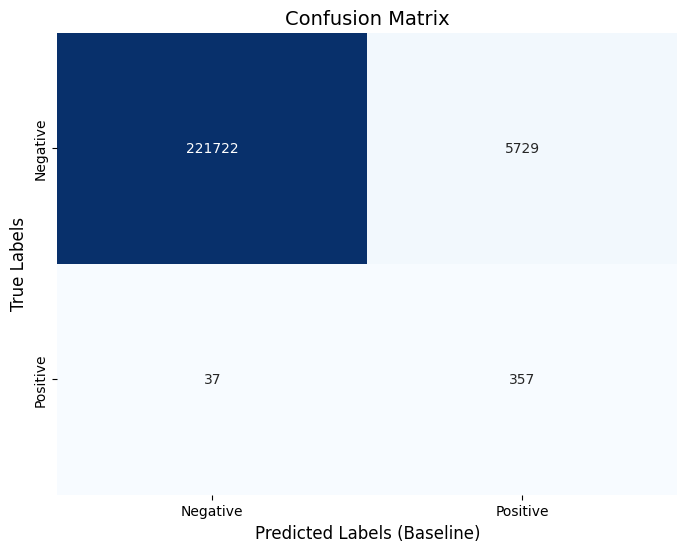

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming y_train and y_pred are already defined
cm = confusion_matrix(y_train, y_pred)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted Labels (Baseline)", fontsize=12)
plt.ylabel("True Labels", fontsize=12)
plt.title("Confusion Matrix", fontsize=14)
plt.savefig(REPORTS_DIR / "cm_baseline.png")
plt.show()


In [94]:

prec, rec, f1 = precision_score(y_train, y_pred), recall_score(y_train, y_pred), f1_score(y_train, y_pred)
print(f"Precision: {prec:.4f}, Recall: {rec:.4f}, F1-Score: {f1:.4f}")

Precision: 0.0587, Recall: 0.9061, F1-Score: 0.1102


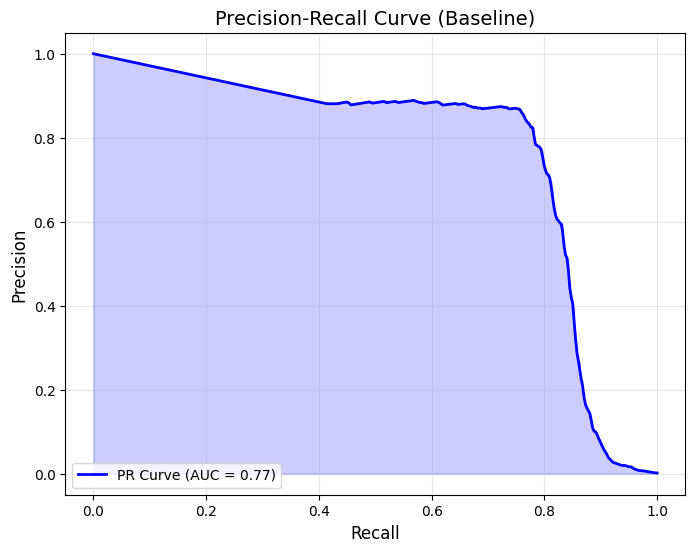

In [95]:
# Generate out-of-fold probabilities
oof_proba = cross_val_predict(model, X_train, y_train, cv=skf, method="predict_proba")[:, 1]

# Compute Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_train, oof_proba)

# Compute Area Under the Curve (AUC) for PR curve
pr_auc = auc(recall, precision)

# Plot Precision-Recall curve using Seaborn
plt.figure(figsize=(8, 6))
sns.lineplot(x=recall, y=precision, label=f"PR Curve (AUC = {pr_auc:.2f})", color="blue", linewidth=2)
plt.fill_between(recall, precision, alpha=0.2, color="blue")  # Shade the area under the curve
plt.xlabel("Recall", fontsize=12)
plt.ylabel("Precision", fontsize=12)
plt.title("Precision-Recall Curve (Baseline)", fontsize=14)
plt.legend(loc="lower left", fontsize=10)
plt.grid(alpha=0.3)

# Save the plot before showing it
plt.savefig(REPORTS_DIR / "pr_curve_baseline.png")

# Show the plot
plt.show()


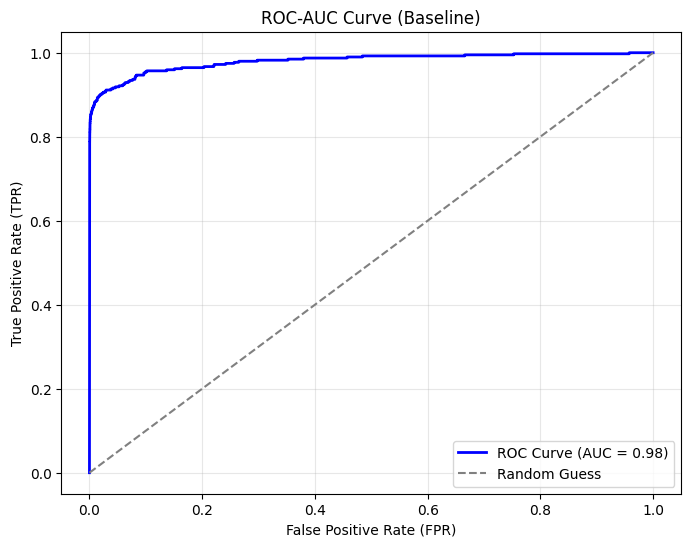

In [96]:
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_train, oof_proba)

# Compute Area Under the Curve (AUC) for ROC curve
roc_auc = roc_auc_score(y_train, oof_proba)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})", color="blue", linewidth=2)
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Guess")  # Diagonal line
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC-AUC Curve (Baseline)")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)

# Save the plot before showing it
plt.savefig(REPORTS_DIR / "roc_auc_curve_baseline.png")

# Show the plot
plt.show()